In [1]:
# Standard library imports
import argparse
import json
import os
import sys
from datetime import date, datetime, time as dtime
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from urllib.parse import urlencode

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
from dotenv import load_dotenv
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from scipy.optimize import curve_fit

# ---------------------------------
# Config
# ---------------------------------
PHASE_CHANGES = '../data/phase_change_data.csv'
RAW_DATA = '../data/raw_data_all_locations.csv'
DAILY_SUMS = '../data/daily_summaries_all_locations.csv'
BIRDCAST_PARQUET = '../../birdcast-data-grabber/data/birdcast_data.parquet'
load_dotenv()

# Time-binning config
TIME_BIN_START_HOUR = 0     # 6 AM
TIME_BIN_END_HOUR = 23      # 8 PM (20 in 24h)
TIME_BIN_MINUTES = 30       # 30-minute bins

# Plot config
PLOTLY_RENDERER = 'browser'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ---------------------------------
# Dashboard Export Functions
# ---------------------------------
# Create dashboard output directory
DASHBOARD_DIR = '../docs/dashboard_plots'
os.makedirs(DASHBOARD_DIR, exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/images', exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/interactive', exist_ok=True)

print(f"Dashboard plots will be saved to: {DASHBOARD_DIR}")

# Function to save matplotlib plots
def save_plot_for_dashboard(fig, filename, title, description=""):
    """Save matplotlib figure for dashboard with metadata."""
    # Save as high-res PNG
    png_path = f'{DASHBOARD_DIR}/images/{filename}.png'
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Create metadata file
    metadata = {
        'title': title,
        'description': description,
        'filename': filename,
        'type': 'matplotlib',
        'created': datetime.now().isoformat(),
        'image_path': f'images/{filename}.png'
    }
    
    with open(f'{DASHBOARD_DIR}/{filename}.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved: {title} -> {filename}")
    return filename

Dashboard plots will be saved to: ../docs/dashboard_plots


In [2]:
# ---------------------------------
# Helpers for time-binning & plots
# ---------------------------------
def build_time_bins(start_hour: int = TIME_BIN_START_HOUR,
                    end_hour: int = TIME_BIN_END_HOUR,
                    step_minutes: int = TIME_BIN_MINUTES) -> Tuple[List[dtime], List[str]]:
    time_bins: List[dtime] = []
    for hour in range(start_hour, end_hour + 1):
        for minute in range(0, 60, step_minutes):
            if hour == end_hour and minute >= 60:
                break
            time_bins.append(dtime(hour, minute))
    time_labels = [t.strftime('%I:%M %p') for t in time_bins]
    return time_bins, time_labels


def assign_time_bin_factory(time_bins: List[dtime]):
    # Returns a function that maps a datetime.time -> index of its bin
    def assign_time_bin(t):
        if t is None or pd.isna(t):
            return None
        t_minutes = t.hour * 60 + t.minute
        for i, bin_time in enumerate(time_bins):
            bin_minutes = bin_time.hour * 60 + bin_time.minute
            if t_minutes < bin_minutes + TIME_BIN_MINUTES:
                return i
        return len(time_bins) - 1
    return assign_time_bin


def prepare_complete_data(raw_df: pd.DataFrame,
                          time_bins: List[dtime]) -> Tuple[pd.DataFrame, List[str], list, list, pd.DataFrame]:
    # Ensure Time column is datetime.time
    if not np.issubdtype(pd.Series(raw_df['Time']).dtype, np.dtype('O')):
        raw_df = raw_df.copy()
        raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%H:%M:%S').dt.time

    time_bins, time_labels = build_time_bins()
    assign_time_bin = assign_time_bin_factory(time_bins)

    df = raw_df.copy()
    df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
    df = df.dropna(subset=['TimeBin'])

    grouped_data = df.groupby(['Date', 'TimeBin']).size().reset_index(name='Count')

    all_dates = sorted(df['Date'].unique())
    all_time_bins = list(range(len(time_bins)))

    complete_grid = pd.DataFrame([(date, tb) for date in all_dates for tb in all_time_bins],
                                 columns=['Date', 'TimeBin'])

    complete_data = complete_grid.merge(grouped_data, on=['Date', 'TimeBin'], how='left').fillna(0)

    dates = sorted(complete_data['Date'].unique())
    time_bin_indices = sorted(complete_data['TimeBin'].unique())
    return complete_data, time_labels, dates, time_bin_indices, grouped_data

def plot_heatmap_counts_subplots(location_data: dict,
                                title: str = 'Heatmap: Date vs Time of Day vs Observation Count') -> None:
    locations = sorted(list(location_data.keys())) 
    n_locations = len(locations)
    
    fig, axes = plt.subplots(1, n_locations, figsize=(12*n_locations, 10))
    
    # Ensure axes is always a list for consistent indexing
    if n_locations == 1:
        axes = [axes]
    
    for i, location in enumerate(locations):
        ax = axes[i]
        complete_data = location_data[location]['complete_data']
        time_labels = location_data[location]['time_labels']
        
        heatmap_data = complete_data.pivot(index='TimeBin', columns='Date', values='Count')
        
        sns.heatmap(
            heatmap_data,
            xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
            yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
            cmap='viridis',
            cbar_kws={'label': 'Count of Observations'},
            annot=True,
            fmt='g',
            linewidths=0.5,
            ax=ax
        )
        
        ax.set_title(location, fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=16, labelpad=12)
        if i==0:
            ax.set_ylabel('Time of Day', fontsize=16, labelpad=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', rotation=0, labelsize=10)
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()
    return fig


def plot_heatmap_proportions_subplots(location_data: dict,
                                     title: str = 'Heatmap: Date vs Time of Day vs Proportion of Observations') -> None:
    locations = sorted(list(location_data.keys())) 
    n_locations = len(locations)
    
    fig, axes = plt.subplots(1, n_locations, figsize=(12*n_locations, 10))
    
    # Ensure axes is always a list for consistent indexing
    if n_locations == 1:
        axes = [axes]
    
    for i, location in enumerate(locations):
        ax = axes[i]
        complete_data = location_data[location]['complete_data']
        time_labels = location_data[location]['time_labels']
        
        complete_with_totals = complete_data.copy()
        complete_with_totals['Daily Total'] = complete_with_totals.groupby('Date')['Count'].transform('sum')
        complete_with_totals['Daily Proportion'] = (complete_with_totals['Count'] / complete_with_totals['Daily Total']).round(2)
        heatmap_data = complete_with_totals.pivot(index='TimeBin', columns='Date', values='Daily Proportion')
        
        sns.heatmap(
            heatmap_data,
            xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
            yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
            cmap='viridis',
            cbar_kws={'label': 'Proportion of Observations'},
            annot=True,
            fmt='g',
            linewidths=0.5,
            ax=ax
        )
        
        ax.set_title(location, fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=16, labelpad=12)
        if i==0:
            ax.set_ylabel('Time of Day', fontsize=16, labelpad=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', rotation=0, labelsize=10)
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()
    return fig

In [3]:
# Load data
raw_data = pd.read_csv(RAW_DATA)
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

daily_summs = pd.read_csv(DAILY_SUMS)
daily_summs['Date'] = pd.to_datetime(daily_summs['Date'])

phase_changes = pd.read_csv(PHASE_CHANGES)

# Source Sheet dicts for renaming
locations_dict = {
    'southampton_uk': 'Southampton, UK',
    'jacksonville_fl_32259': 'Jacksonville, FL',
    'essex_fells_nj_07021': 'Essex Fells, NJ',
}
raw_data['source_sheet'] = raw_data['source_sheet'].map(locations_dict)

locations_dict = {
    'Southampton daily summaries': 'Southampton, UK',
    'Jacksonville, FL 32259 Daily Su': 'Jacksonville, FL',
    'Essex Fells, NJ 07021 Daily Sum': 'Essex Fells, NJ',
}
daily_summs['source_sheet'] = daily_summs['source_sheet'].map(locations_dict)

# Basic plots of the action

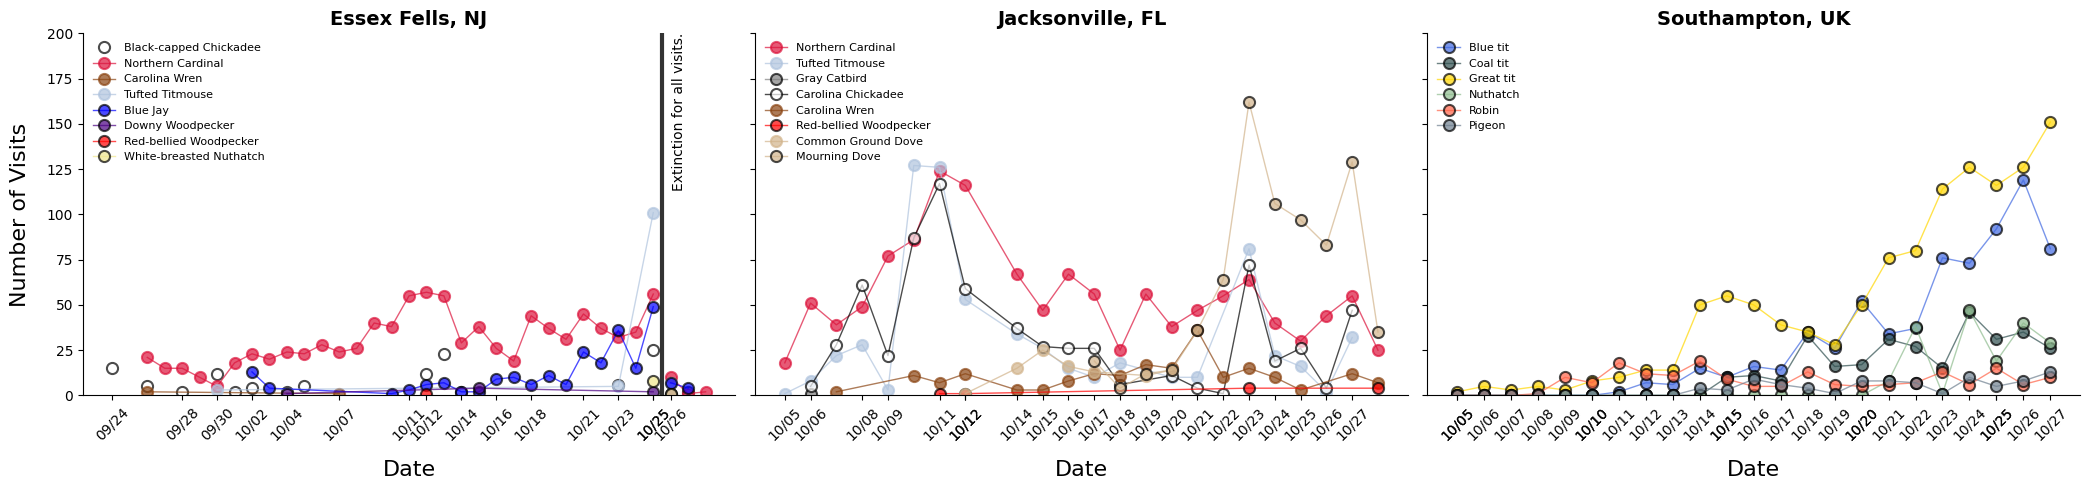


All birds have predefined colors!


In [ ]:
# Define custom colors for each bird species
bird_colors = {
    'Northern Cardinal': '#DC143C',         # Cardinal red
    'Tufted Titmouse': '#B0C4DE',           # Light blue gray
    'Gray Catbird': '#808080',              # Gray
    'Carolina Chickadee': '#FFFFFF',        # White
    'Carolina Wren': '#8B4513',             # Medium brown
    'Red-bellied Woodpecker': '#FF0000',    # Red
    'Common Ground Dove': '#D2B48C',        # Tan
    'Mourning Dove': '#D2B48C',             # Tan
    'Downy Woodpecker': '#4B0082',          # Indigo (dark blue-purple)
    'Pigeon.1': '#708090',                  # Slate gray
    'Robin': '#FF6347',                     # Tomato red-orange
    'Coal tit': '#2F4F4F',                  # Dark slate gray
    'White-breasted Nuthatch': '#F0E68C',   # Khaki (light yellow-green)
    'Black-capped Chickadee': '#FFFFFF',     # White
    'Blue tit': '#4169E1',                  # Royal blue
    'Pigeon': '#708090',                    # Slate gray
    'Blue Jay': '#0000FF',                  # Blue
    'Great tit': '#FFD700',                 # Gold
    'Nuthatch': '#8FBC8F',                  # Dark sea green
}

# Define marker edge colors for birds that need black outlines
bird_edge_colors = {
    'Northern Cardinal': '#DC143C',
    'Tufted Titmouse': '#B0C4DE',
    'Gray Catbird': 'black',
    'Carolina Chickadee': 'black',
    'Carolina Wren': '#8B4513',
    'Red-bellied Woodpecker': 'black',
    'Common Ground Dove': '#D2B48C',
    'Mourning Dove': 'black',
    'Downy Woodpecker': 'black',
    'Pigeon.1': 'black',
    'Robin': 'black',
    'Coal tit': 'black',
    'White-breasted Nuthatch': 'black',
    'Black-capped Chickadee': 'black',
    'Blue tit': 'black',
    'Pigeon': 'black',
    'Blue Jay': 'black',
    'Great tit': 'black',
    'Nuthatch': 'black',
}

# Get unique locations
locations = sorted(daily_summs['source_sheet'].unique())
n_locations = len(locations)

# Create 1x3 subplot layout
fig, axes = plt.subplots(1, n_locations, figsize=(7*n_locations, 5), sharey=True)

# Ensure axes is always a list for consistent indexing
if n_locations == 1:
    axes = [axes]

# Track birds that need specific colors
birds_needing_colors = set()

# Plot each location separately
for i, location in enumerate(locations):
    ax = axes[i]
    location_data = daily_summs[daily_summs['source_sheet'] == location].dropna(subset=['Bird'])
    
    # Check for phase changes for this location
    location_phase_changes = phase_changes[phase_changes['LocationOfChange'] == location]
    
    # Get the phase change date if it exists
    phase_change_date = None
    if not location_phase_changes.empty:
        phase_change_date = pd.to_datetime(location_phase_changes.iloc[0]['DateChangeStarted'])
        description = location_phase_changes.iloc[0]['DescriptionOfChange']
    
    # Plot each bird species individually with custom colors
    for bird in location_data['Bird'].unique():
        bird_data = location_data[location_data['Bird'] == bird].copy()
        bird_data = bird_data.sort_values('Date')
        
        # Check if bird has predefined colors
        if bird in bird_colors:
            line_color = bird_colors[bird]
            marker_color = bird_colors[bird]
            edge_color = bird_edge_colors.get(bird, 'black')
        else:
            # Generate random colors for unknown birds
            np.random.seed(hash(bird) % 2**32)  # Consistent colors per bird
            line_color = f'#{np.random.randint(0, 0xFFFFFF):06x}'
            marker_color = line_color
            edge_color = 'black'
            birds_needing_colors.add(bird)
        
        # Special handling for Carolina Chickadee
        if (bird == 'Carolina Chickadee') or (bird == 'Black-capped Chickadee'):
            line_color = '#000000'  # Black line
            marker_color = '#FFFFFF'  # White marker
        
        # Split data at phase change if it exists
        if phase_change_date is not None:
            # Split data into before and after phase change
            before_change = bird_data[bird_data['Date'] < phase_change_date]
            after_change = bird_data[bird_data['Date'] >= phase_change_date]
            
            # Plot before phase change
            if not before_change.empty:
                ax.plot(
                    before_change['Date'], 
                    before_change['Feeder Visits'], 
                    marker='o', 
                    markersize=8,
                    markerfacecolor=marker_color,
                    markeredgecolor=edge_color,
                    markeredgewidth=1.5,
                    linewidth=1,
                    color=line_color,
                    label=bird if i == 0 else "",  # Only label once
                    alpha=0.7
                )
            
            # Plot after phase change
            if not after_change.empty:
                ax.plot(
                    after_change['Date'], 
                    after_change['Feeder Visits'], 
                    marker='o', 
                    markersize=8,
                    markerfacecolor=marker_color,
                    markeredgecolor=edge_color,
                    markeredgewidth=1.5,
                    linewidth=1,
                    color=line_color,
                    label="",  # No label for second segment
                    alpha=0.7
                )
        else:
            # No phase change, plot normally
            ax.plot(
                bird_data['Date'], 
                bird_data['Feeder Visits'], 
                marker='o', 
                markersize=8,
                markerfacecolor=marker_color,
                markeredgecolor=edge_color,
                markeredgewidth=1.5,
                linewidth=1,
                color=line_color,
                label=bird, 
                alpha=0.7
            )
    
    # Add phase change vertical lines for this location
    for _, phase_row in location_phase_changes.iterrows():
        change_date = pd.to_datetime(phase_row['DateChangeStarted'])
        description = phase_row['DescriptionOfChange']
        
        # Find the date before the change date
        location_dates = location_data['Date'].unique()
        location_dates = pd.to_datetime(location_dates)
        location_dates = np.sort(location_dates)
        
        # Find the date before the change date
        before_change_idx = np.where(location_dates < change_date)[0]
        if len(before_change_idx) > 0:
            date_before = location_dates[before_change_idx[-1]]
            # Calculate halfway point
            halfway_date = date_before + (change_date - date_before) / 2
            
            # Add vertical line
            ax.axvline(x=halfway_date, color='black', linestyle='-', linewidth=3, alpha=0.8)
            
            # Add description text
            ymax = daily_summs['Feeder Visits'].max()
            ax.text(halfway_date + pd.Timedelta(days=1), ymax * 1.25, description, 
                rotation=90, ha='center', va='top', fontsize=10)
    
    # Set labels and formatting for each subplot
    if i == 0:
        ax.set_ylabel('Number of Visits', fontsize=16, labelpad=12)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Date', fontsize=16, labelpad=12)
    ax.set_title(location, fontsize=14, fontweight='bold')
    
    # Set x-axis ticks (every 5th day)
    ticks = location_data['Date']
    ax.set_xticks(ticks[::5], labels=ticks[::5].dt.strftime('%m/%d'), rotation=45)
    ax.tick_params(labelsize=10)
    for label in ax.get_xticklabels():
        label.set_fontweight('normal')
        label.set_fontfamily('sans-serif')
    
    ax.set_ylim(0, 200)
    sns.despine(top=True, right=True)
    
    ax.legend(loc="upper left", frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

# Print birds that need specific colors
if birds_needing_colors:
    print("\nBirds that need specific colors added to bird_colors dictionary:")
    for bird in birds_needing_colors:
        print(f"    '{bird}'")
else:
    print("\nAll birds have predefined colors!")

In [5]:
# Save species visits plot for dashboard
save_plot_for_dashboard(
    fig, 
    'species_visits_by_date', 
    'Daily Bird Feeder Visits by Species',
    'Line plot showing daily feeder visits for each bird species with custom color coding'
)


Saved: Daily Bird Feeder Visits by Species -> species_visits_by_date


'species_visits_by_date'

## Set up data for heatmap plots

In [6]:
# Build complete data and plot 3D surface using helpers for each location
_time_bins, _time_labels = build_time_bins()

# Dictionary to store data for each location
location_data = {}

# Get unique locations
locations = raw_data['source_sheet'].unique()

# Prepare complete data for each location
for location in locations:
    location_raw_data = raw_data[raw_data['source_sheet'] == location]
    complete_data, time_labels, dates, time_bin_indices, grouped_data = prepare_complete_data(location_raw_data, _time_bins)
    
    location_data[location] = {
        'complete_data': complete_data,
        'time_labels': time_labels,
        'dates': dates,
        'time_bin_indices': time_bin_indices,
        'grouped_data': grouped_data
    }

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/3951363588.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/3951363588.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/3951363588.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_

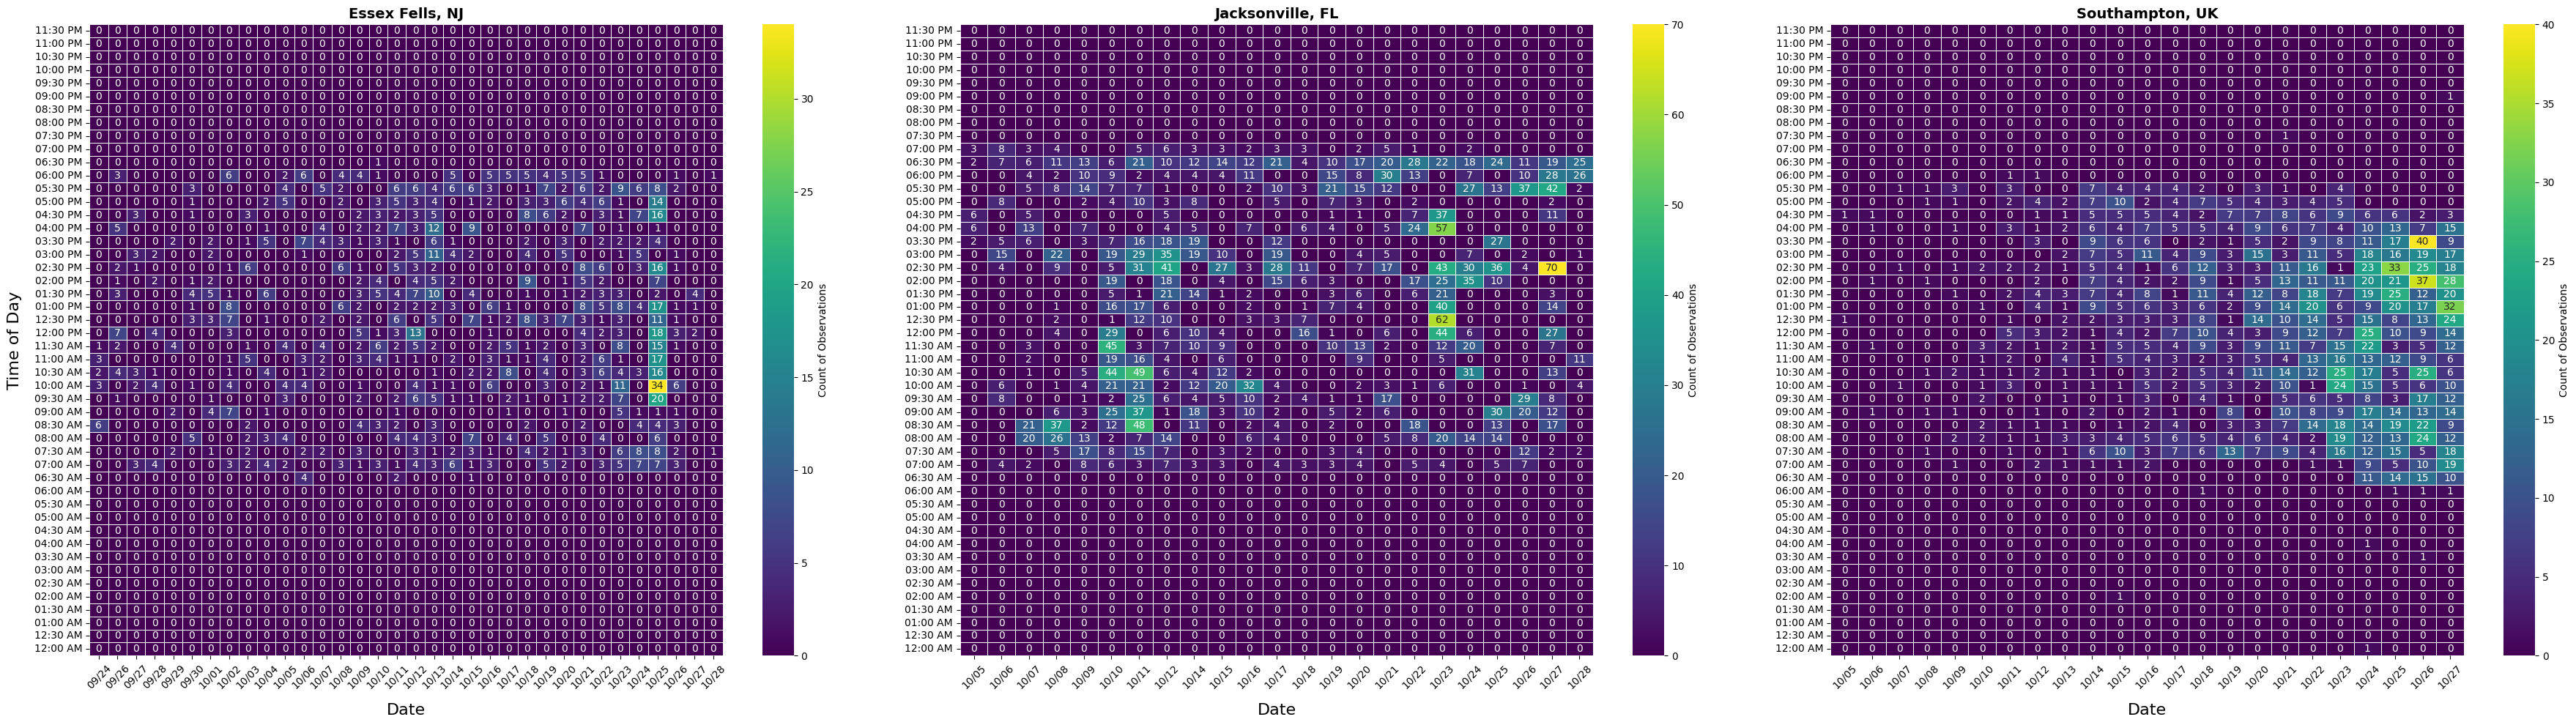

Saved: Heatmap: Date vs Time of Day vs Observation Count -> heatmap_counts


'heatmap_counts'

In [7]:
# Plot heatmaps for each location
fig = plot_heatmap_counts_subplots(location_data)

# Save heatmap plots for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_counts', 
    'Heatmap: Date vs Time of Day vs Observation Count',
    'Heatmap showing bird activity patterns across dates and times of day for each location'
)

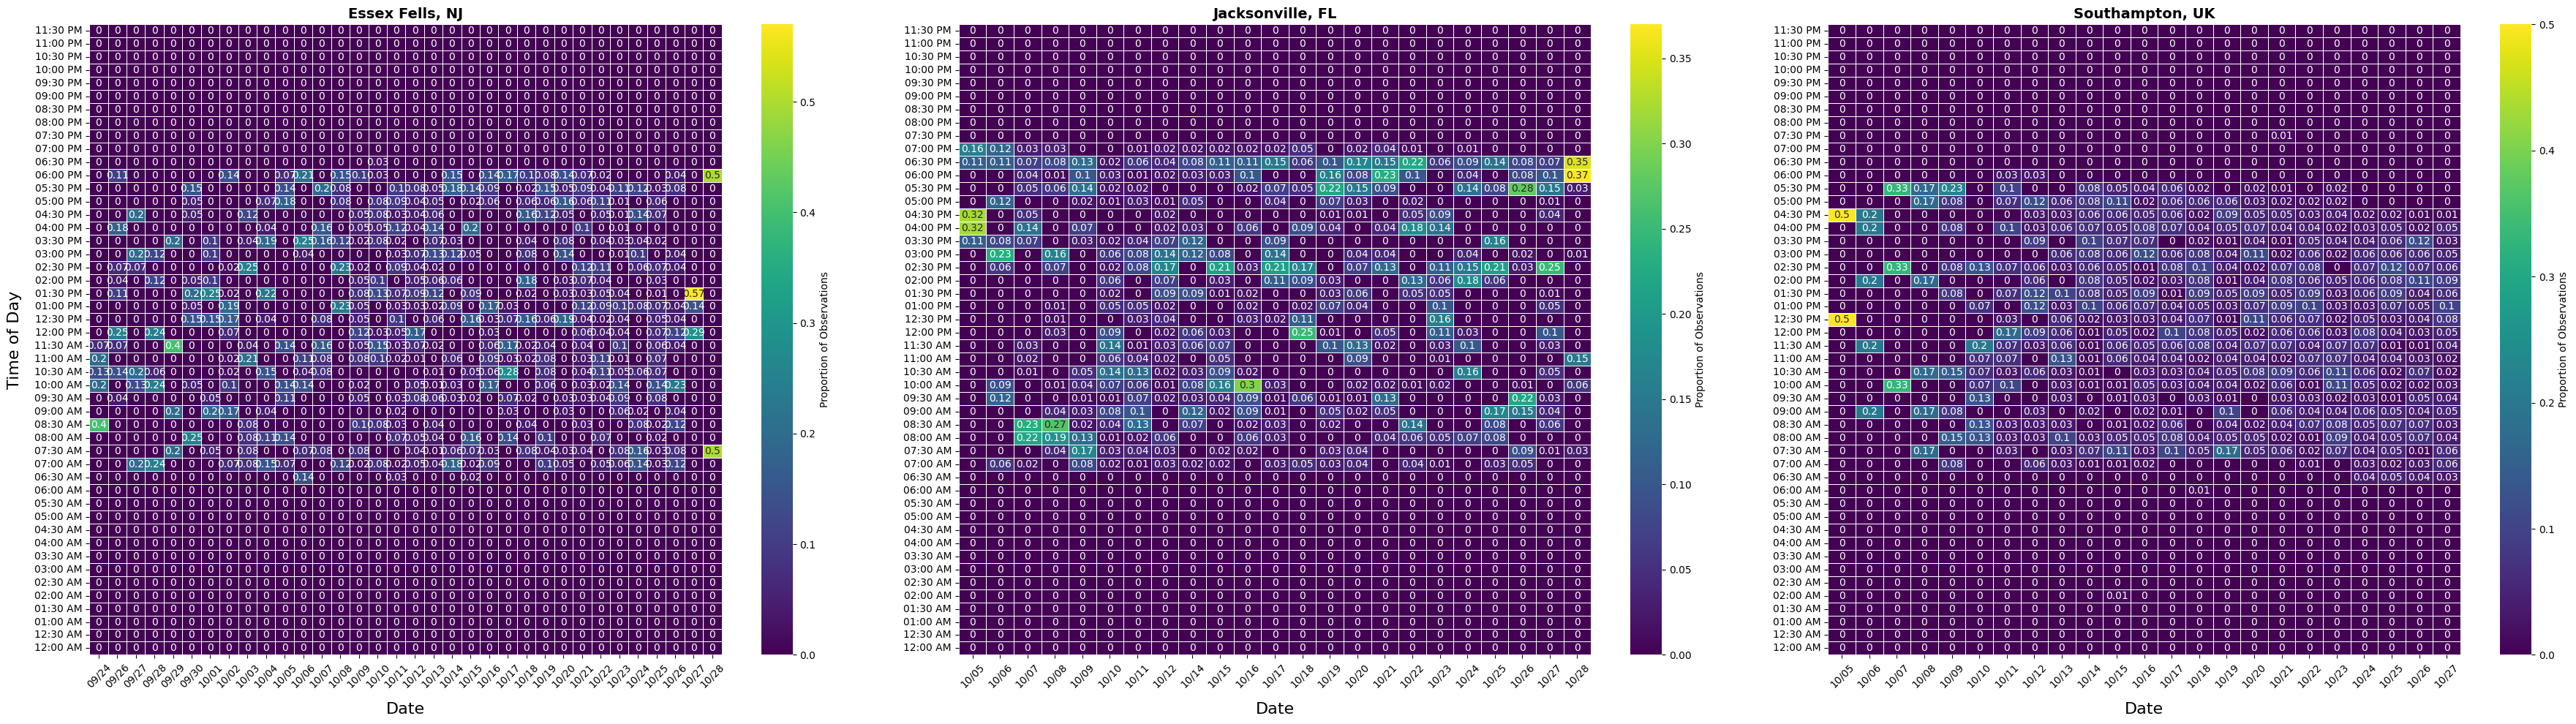

Saved: Heatmap: Date vs Time of Day vs Proportion of Observations -> heatmap_proportions


'heatmap_proportions'

In [8]:
# Plot proportions heatmaps for each location
fig = plot_heatmap_proportions_subplots(location_data)

# Save proportions heatmap for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_proportions', 
    'Heatmap: Date vs Time of Day vs Proportion of Observations',
    'Heatmap showing proportional bird activity patterns across dates and times of day for each location'
)

# Bout Analyses

In [9]:
# Add inter-visit interval (IVI) data 
raw_data_ivi = pd.DataFrame()
for location in raw_data['source_sheet'].unique():
    location_data = raw_data[raw_data['source_sheet'] == location].copy()
    
    # Convert to datetime
    location_data['Date'] = pd.to_datetime(location_data['Date'])
    location_data['Time'] = pd.to_datetime(location_data['Time'])
    
    # Combine date and time, handling NaT values
    location_data['date_time'] = location_data['Date'] + pd.to_timedelta(location_data['Time'].dt.hour, unit='h') + pd.to_timedelta(location_data['Time'].dt.minute, unit='m') + pd.to_timedelta(location_data['Time'].dt.second, unit='s')
    location_data = location_data.sort_values(by='date_time', ascending=True).reset_index(drop=True)
    
    # Calculate IVI (inter-visit interval) in minutes
    location_data['IVI (mins)'] = location_data['date_time'].diff().dt.total_seconds() / 60
    
    raw_data_ivi = pd.concat([raw_data_ivi, location_data])

raw_data_ivi = raw_data_ivi.dropna(subset=['IVI (mins)'])

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/165320574.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/165320574.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/165320574.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])


/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/1737159152.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/1737159152.py:7: RuntimeWarning: invalid value encountered in log
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/1737159152.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/1737159152.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_22827/1737159152.py:7: RuntimeWarning: invalid value encountered in log
  return np.log(A1 * np.exp(-lambda1 * t) + 

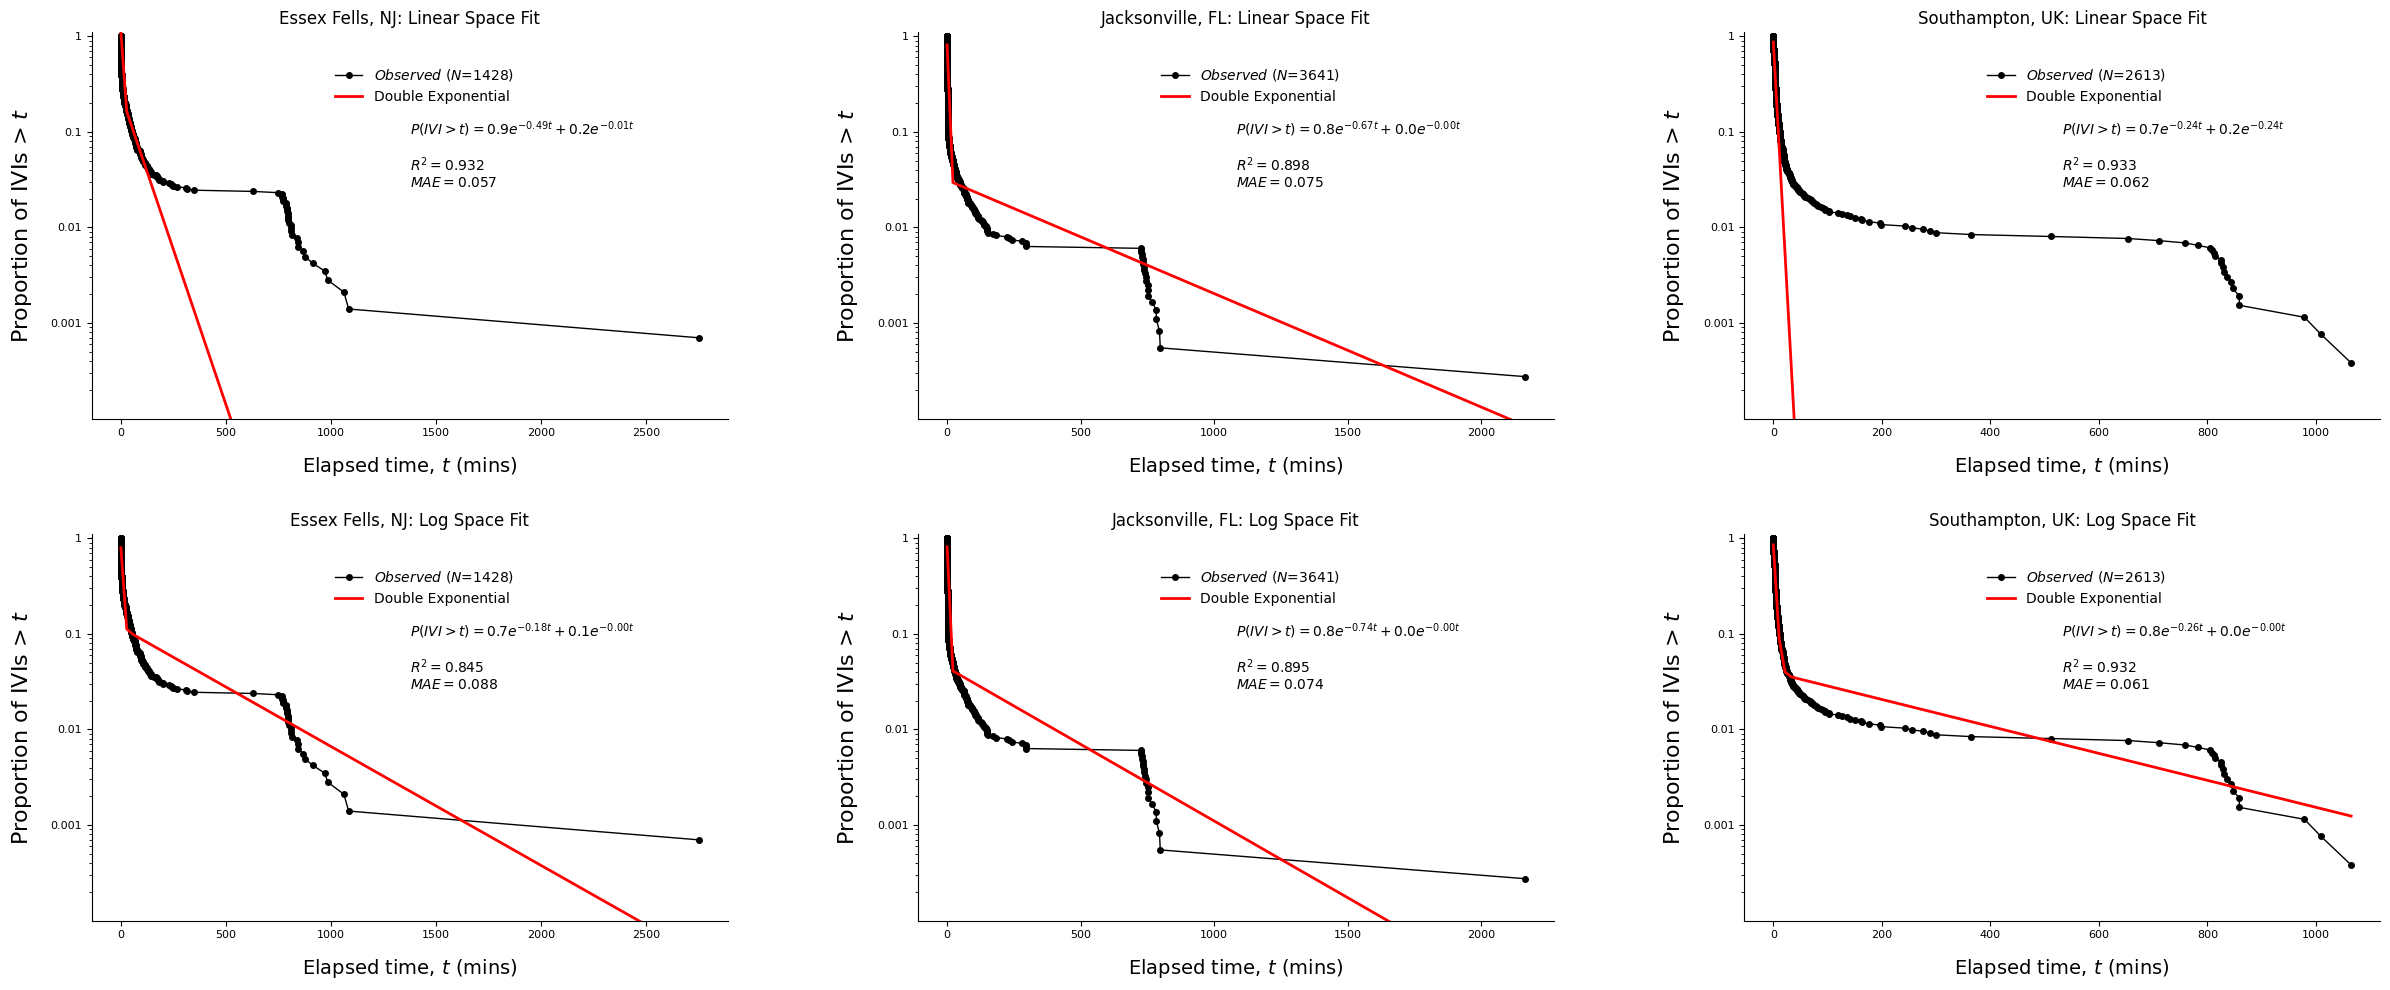

In [10]:
def double_exponential_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential survivor function"""
    return A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t)

def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

# Get unique locations
locations = sorted(raw_data_ivi['source_sheet'].unique())
n_locations = len(locations)

# Create 2x3 subplot layout (2 rows for fit types, 3 columns for locations)
fig, axes = plt.subplots(2, n_locations, figsize=(8*n_locations, 10))

# Ensure axes is always a 2D array for consistent indexing
if n_locations == 1:
    axes = axes.reshape(2, 1)

# Process each location
for col, location in enumerate(locations):
    # Get IVI data for this location (remove NaN values)
    location_data = raw_data_ivi[raw_data_ivi['source_sheet'] == location]
    ivi_data = location_data['IVI (mins)'].dropna()
    
    if len(ivi_data) == 0:
        # Skip if no data for this location
        continue
    
    # Sort the data
    sorted_ivi = np.sort(ivi_data)
    
    # Calculate survivor function
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    
    # Create time points for fitting (use the sorted IVI values)
    time_points = sorted_ivi
    
    # Initial parameter guesses
    initial_guess = [0.4, 0.5, 0.6, 0.02]
    
    # Fit the double exponential model to survivor function (linear space)
    try:
        popt_linear, pcov_linear = curve_fit(double_exponential_survivor, time_points, survivor, 
                             p0=initial_guess, maxfev=10000)
        
        # Fit the double exponential model in log space
        log_survivor = np.log(survivor + 1e-10)
        popt_log, pcov_log = curve_fit(double_exponential_log_survivor, time_points, log_survivor, 
                             p0=initial_guess, maxfev=10000)
        
        # Calculate R-squared and MAE for linear fit
        y_pred_linear = double_exponential_survivor(time_points, *popt_linear)
        r_squared_linear = 1 - (np.sum((survivor - y_pred_linear) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
        mae_linear = round(np.mean(np.abs(survivor - y_pred_linear)), 4)
        
        # Calculate R-squared and MAE for log fit
        y_pred_log = double_exponential_log_survivor(time_points, *popt_log)
        y_pred_log_linear = np.exp(y_pred_log)
        r_squared_log = 1 - (np.sum((survivor - y_pred_log_linear) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
        mae_log = round(np.mean(np.abs(survivor - y_pred_log_linear)), 4)
        
        # Plot 1: Linear space fit (top row)
        ax1 = axes[0, col]
        ax1.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                     label=f'$Observed$ ($N$={len(ivi_data)})')
        
        # Plot fitted model
        t_smooth = np.linspace(0, ivi_data.max(), 100)
        y_smooth = double_exponential_survivor(t_smooth, *popt_linear)
        ax1.semilogy(t_smooth, y_smooth, 'r-', linewidth=2, 
                     label=f'Double Exponential')
        
        text_x = 0.5
        
        ax1.set_xlabel('Elapsed time, $t$ (mins)', fontsize=14, labelpad=12)
        ax1.set_ylabel(f'Proportion of IVIs > $t$', fontsize=16, labelpad=12)
        ax1.legend(loc=(text_x-0.127, 0.8), fontsize=10, frameon=False)
        ax1.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
                       labels=['0.001', '0.01', '0.1', '1'], 
                       fontsize=8)
        ax1.tick_params(axis='x', labelsize=8)
        ax1.set_ylim(0.0001, 1.1)
        
        # Add equation text with LaTeX formatting
        equation_text = f'$P(IVI>t) = {popt_linear[0]:.1f}e^{{-{popt_linear[1]:.2f}t}} + {popt_linear[2]:.1f}e^{{-{popt_linear[3]:.2f}t}}$'
        ax1.text(text_x, 0.735, equation_text, transform=ax1.transAxes, 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10)
        
        # Add metrics text
        metrics_text = f'$R^2 = {r_squared_linear:.3f}$\n$MAE = {mae_linear:.3f}$'
        ax1.text(text_x, 0.6, metrics_text, transform=ax1.transAxes, 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10)
        
        ax1.set_title(f"{location}: Linear Space Fit", fontsize=12)
        sns.despine(top=True, right=True, ax=ax1)
        
        # Plot 2: Log space fit (bottom row)
        ax2 = axes[1, col]
        ax2.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                     label=f'$Observed$ ($N$={len(ivi_data)})')
        
        # Plot fitted model (transform back to linear space)
        y_smooth_log = double_exponential_log_survivor(t_smooth, *popt_log)
        y_smooth_log_linear = np.exp(y_smooth_log)
        ax2.semilogy(t_smooth, y_smooth_log_linear, 'r-', linewidth=2, 
                     label=f'Double Exponential')
        
        ax2.set_xlabel('Elapsed time, $t$ (mins)', fontsize=14, labelpad=12)
        ax2.set_ylabel(f'Proportion of IVIs > $t$', fontsize=16, labelpad=12)
        ax2.legend(loc=(text_x-0.127, 0.8), fontsize=10, frameon=False)
        ax2.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
                       labels=['0.001', '0.01', '0.1', '1'], 
                       fontsize=8)
        ax2.tick_params(axis='x', labelsize=8)
        ax2.set_ylim(0.0001, 1.1)
        
        # Add equation text with LaTeX formatting
        equation_text = f'$P(IVI>t) = {popt_log[0]:.1f}e^{{-{popt_log[1]:.2f}t}} + {popt_log[2]:.1f}e^{{-{popt_log[3]:.2f}t}}$'
        ax2.text(text_x, 0.735, equation_text, transform=ax2.transAxes, 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10)
        
        # Add metrics text
        metrics_text = f'$R^2 = {r_squared_log:.3f}$\n$MAE = {mae_log:.3f}$'
        ax2.text(text_x, 0.6, metrics_text, transform=ax2.transAxes, 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10)
        
        ax2.set_title(f"{location}: Log Space Fit", fontsize=12)
        sns.despine(top=True, right=True, ax=ax2)
        
    except Exception as e:
        print(f"Error fitting data for {location}: {e}")
        # Add error message to subplots
        axes[0, col].text(0.5, 0.5, f"Error fitting data\nfor {location}", 
                         transform=axes[0, col].transAxes, ha='center', va='center')
        axes[1, col].text(0.5, 0.5, f"Error fitting data\nfor {location}", 
                         transform=axes[1, col].transAxes, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [11]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'all_birds_bout_analysis', 
    'All Birds: Bout Analysis',
    'Analysis of bout durations for all birds'
)

Saved: All Birds: Bout Analysis -> all_birds_bout_analysis


'all_birds_bout_analysis'

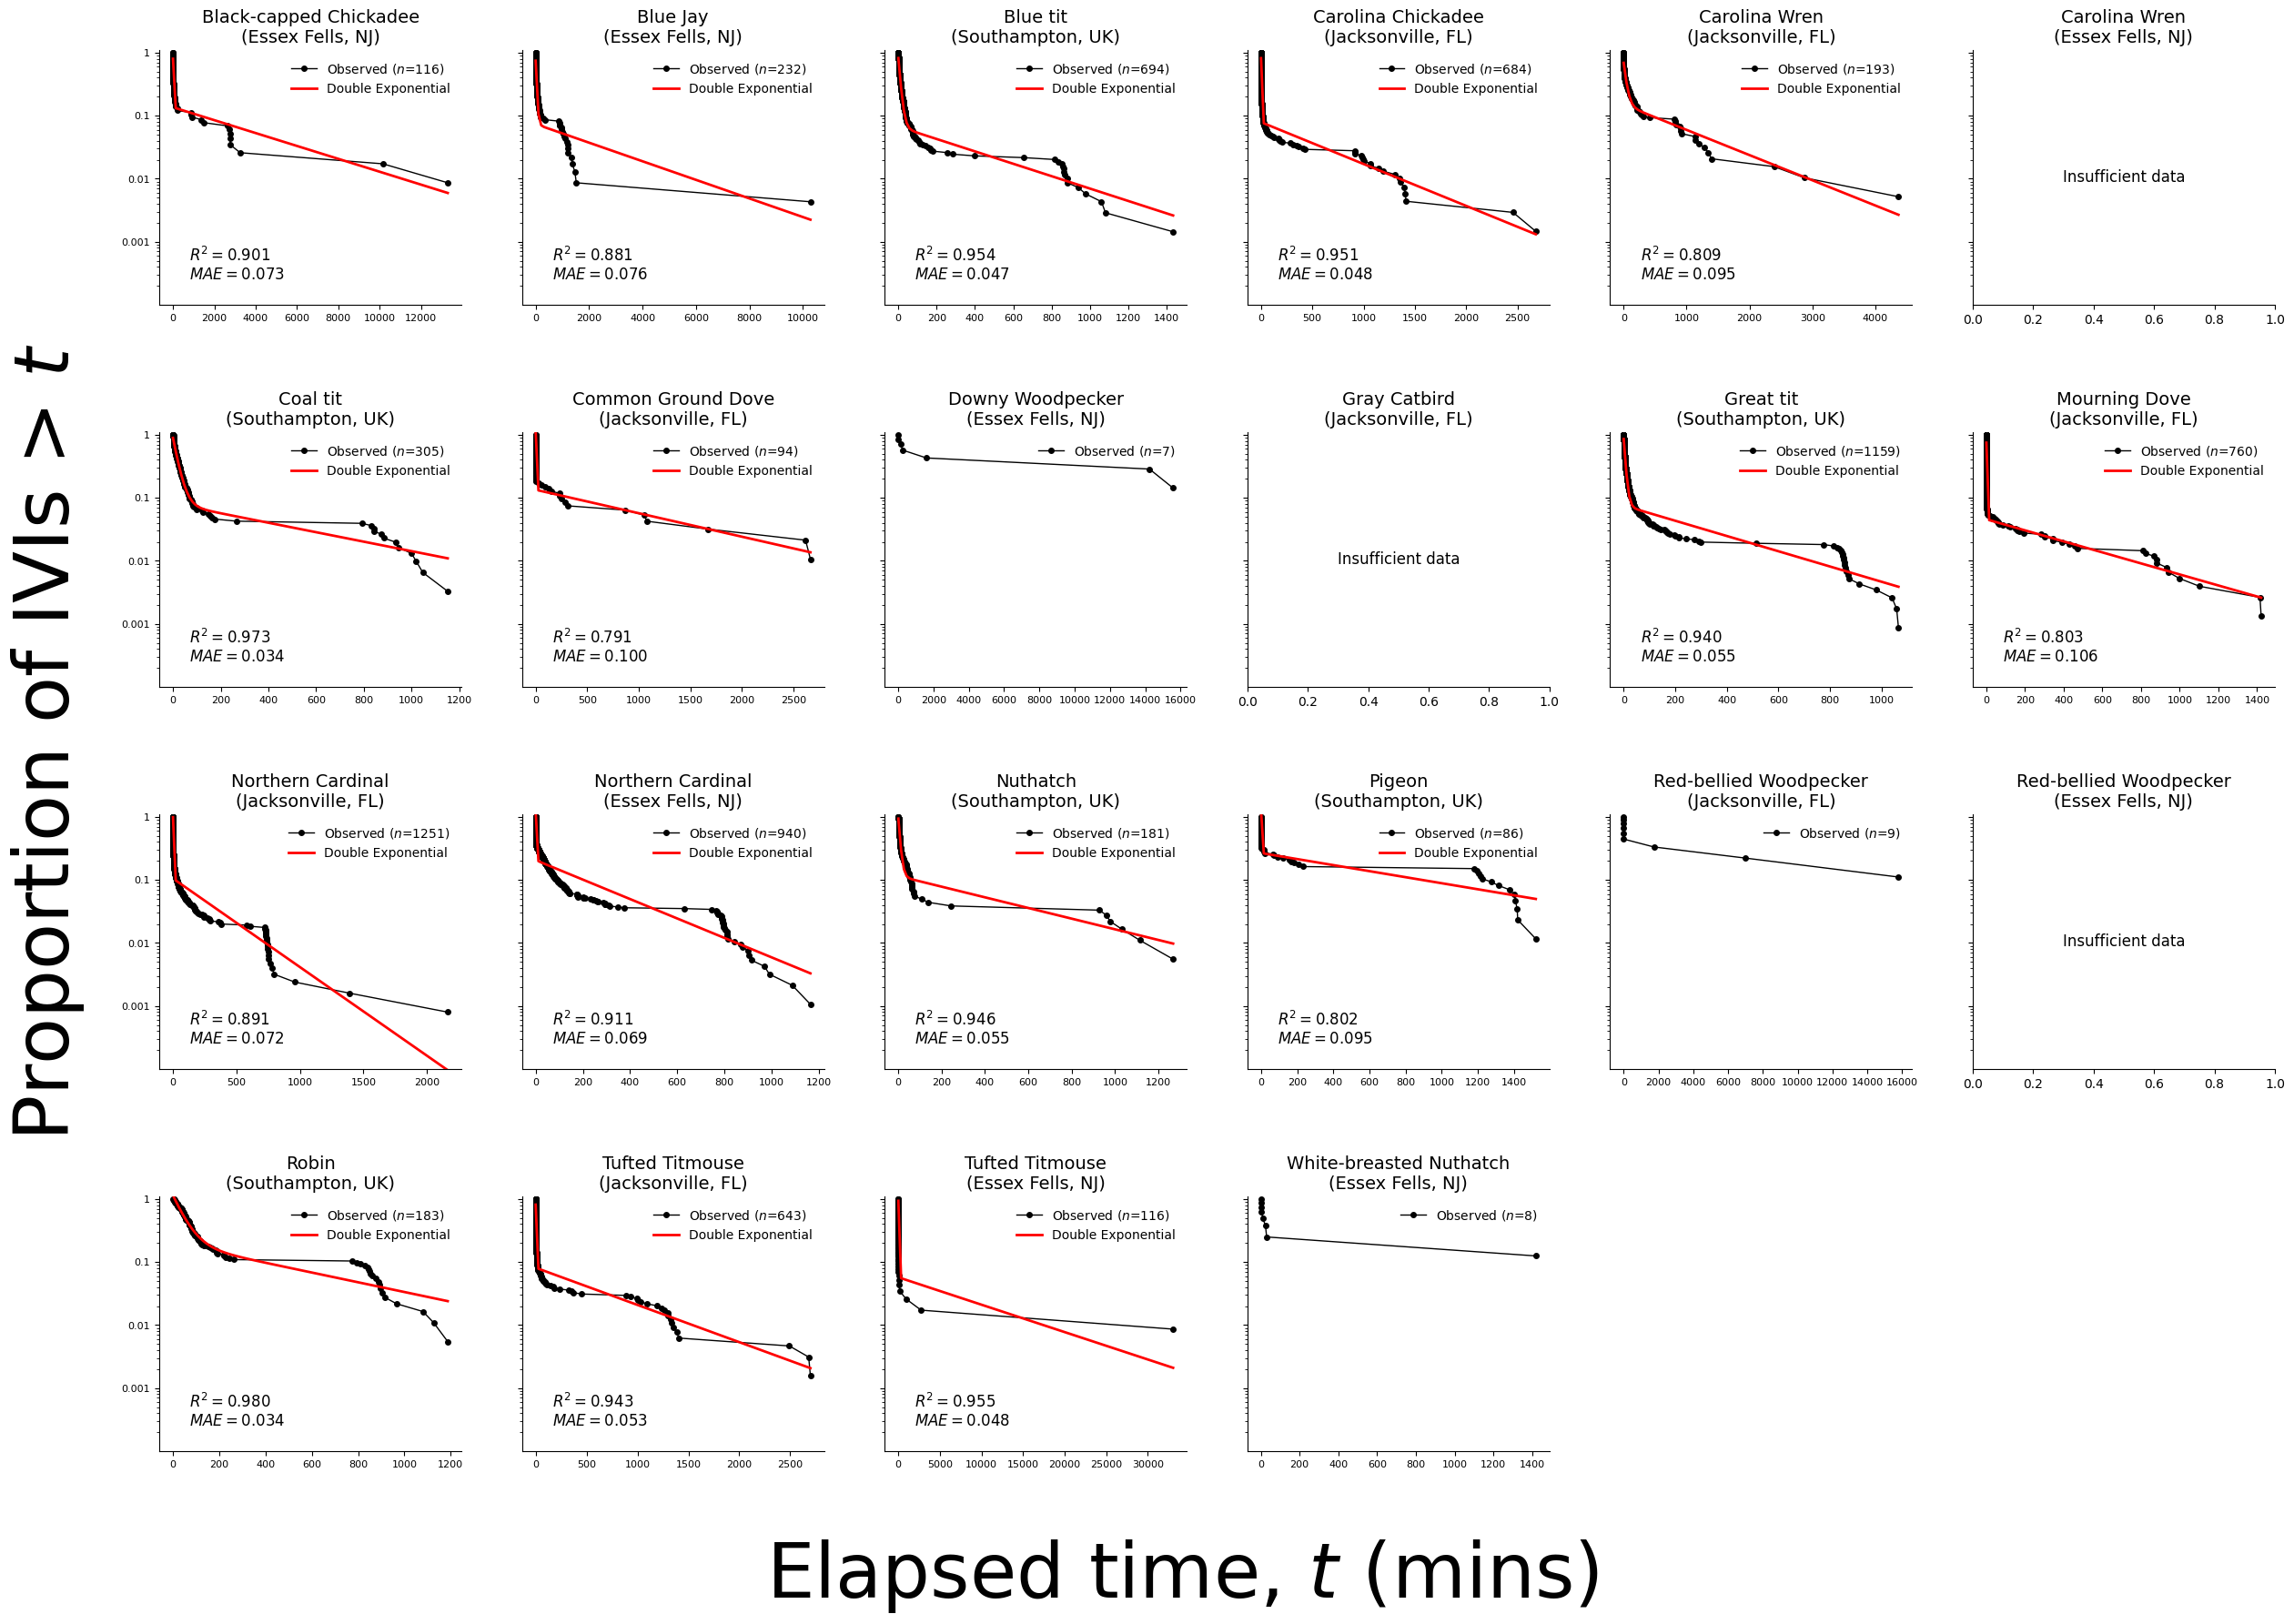

In [12]:
def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

def fit_bout_model_for_bird(data, bird_species):
    bird_data = data[data['Bird'] == bird_species]['IVI (mins)'].dropna()
    
    if len(bird_data) < 10:
        return None, None, None, None
    
    sorted_ivi = np.sort(bird_data)
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    time_points = sorted_ivi
    
    # Work in log-space
    log_survivor = np.log(survivor + 1e-10)
    
    # More flexible initial guess based on data characteristics
    mean_ivi = bird_data.mean()
    std_ivi = bird_data.std()
    
    # Try multiple initial guesses
    initial_guesses = [
        [0.8, 1.0/mean_ivi, 0.2, 0.01/mean_ivi],  # Original
        [0.6, 0.5/mean_ivi, 0.4, 0.05/mean_ivi],   # Alternative 1
        [0.9, 2.0/mean_ivi, 0.1, 0.001/mean_ivi],   # Alternative 2
        [0.5, 0.1/mean_ivi, 0.5, 0.1/mean_ivi],     # Alternative 3
    ]
    
    # Much more relaxed bounds
    bounds = ([0.01, 0.001, 0.01, 0.0001], [1.0, 50, 1.0, 10])
    
    for initial_guess in initial_guesses:
        try:
            # Fit in log-space
            popt, pcov = curve_fit(double_exponential_log_survivor, time_points, log_survivor, 
                                 p0=initial_guess, bounds=bounds, maxfev=20000)
            
            # Convert back to linear space for evaluation
            y_pred_log = double_exponential_log_survivor(time_points, *popt)
            y_pred = np.exp(y_pred_log)
            
            # Calculate metrics in linear space
            r_squared = 1 - (np.sum((survivor - y_pred) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
            mae = np.mean(np.abs(survivor - y_pred))
            
            # Only return if we get a reasonable fit
            if r_squared > 0.5:  # Minimum R² threshold
                return popt, pcov, r_squared, mae
                
        except:
            continue
    
    return None, None, None, None

# First, calculate IVIs for each bird separately
raw_data_ivi = pd.DataFrame()

# Get unique bird-location combinations
raw_data = raw_data.dropna(subset=['Bird'])
# raw_data = raw_data[raw_data['Bird'] != 'Gray Catbird']
bird_location_pairs = raw_data[['Bird', 'source_sheet']].drop_duplicates()

for _, row in bird_location_pairs.iterrows():
    bird = row['Bird']
    location = row['source_sheet']
    
    # Get data for this specific bird-location combination
    bird_data = raw_data[(raw_data['Bird'] == bird) & (raw_data['source_sheet'] == location)].copy()
    
    if len(bird_data) < 5:  # Skip if insufficient data
        continue
    
    # Convert to datetime with explicit format to avoid warnings
    bird_data['Date'] = pd.to_datetime(bird_data['Date'], format='%Y-%m-%d')
    bird_data['Time'] = pd.to_datetime(bird_data['Time'], format='%H:%M:%S')
    
    # Combine date and time, handling NaT values
    bird_data['date_time'] = bird_data['Date'] + pd.to_timedelta(bird_data['Time'].dt.hour, unit='h') + pd.to_timedelta(bird_data['Time'].dt.minute, unit='m') + pd.to_timedelta(bird_data['Time'].dt.second, unit='s')
    bird_data = bird_data.sort_values(by='date_time', ascending=True).reset_index(drop=True)
    
    # Calculate IVI (inter-visit interval) in minutes
    bird_data['IVI (mins)'] = bird_data['date_time'].diff().dt.total_seconds() / 60
    
    raw_data_ivi = pd.concat([raw_data_ivi, bird_data])

# Remove rows with NaN IVI values
raw_data_ivi = raw_data_ivi.dropna(subset=['IVI (mins)'])

# Sort by bird name
bird_location_pairs = bird_location_pairs.sort_values('Bird')

# Calculate number of subplots needed for square-ish layout
n_species = len(bird_location_pairs)
n_cols = 6
n_rows = int(np.ceil(n_species / n_cols))  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), sharey=True)
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Plot for each bird species
for i, (_, row) in enumerate(bird_location_pairs.iterrows()):
    bird = row['Bird']
    location = row['source_sheet']
    
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axes[row_idx, col_idx]
    
    # Get data for this bird-location combination
    bird_data = raw_data_ivi[(raw_data_ivi['Bird'] == bird) & (raw_data_ivi['source_sheet'] == location)]['IVI (mins)'].dropna()
    
    if len(bird_data) < 5:
        ax.text(0.5, 0.5, f'Insufficient data', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{bird}\n({location})', fontsize=14)
        sns.despine(top=True, right=True)
        continue
    
    # Sort the data
    sorted_ivi = np.sort(bird_data)
    
    # Calculate survivor function
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    
    # Create time points for fitting
    time_points = sorted_ivi
    
    # Fit the model
    popt, pcov, r_squared, mae = fit_bout_model_for_bird(raw_data_ivi[(raw_data_ivi['Bird'] == bird) & (raw_data_ivi['source_sheet'] == location)], bird)
    
    if popt is not None:
        # Plot observed data
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
        
        # Plot fitted model - transform back to linear space
        t_smooth = np.linspace(0, bird_data.max(), 100)
        y_smooth_log = double_exponential_log_survivor(t_smooth, *popt)
        y_smooth = np.exp(y_smooth_log)
        ax.semilogy(t_smooth, y_smooth, 'r-', linewidth=2, 
                   label=f'Double Exponential')
        
        # Plot individual components - transform back to linear space
        within_bout_log = np.log(popt[0] * np.exp(-popt[1] * t_smooth) + 1e-10)
        between_bout_log = np.log(popt[2] * np.exp(-popt[3] * t_smooth) + 1e-10)
        within_bout = np.exp(within_bout_log)
        between_bout = np.exp(between_bout_log)
        
        text_x = 0.1
        
        # Add metrics text
        metrics_text = f'$R^2 = {r_squared:.3f}$\n$MAE = {mae:.3f}$'
        ax.text(text_x, 0.1, metrics_text, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
               fontsize=12)
    else:
        # Plot just the observed data if model fitting failed
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
    
    # Remove individual labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set formatting
    ax.legend(loc='best', fontsize=10, frameon=False)
    ax.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
                  labels=['0.001', '0.01', '0.1', '1'], 
                  fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylim(0.0001, 1.1)
    ax.set_title(f'{bird}\n({location})', fontsize=14)
    
    sns.despine(top=True, right=True)

# Hide empty subplots
for i in range(n_species, n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].set_visible(False)

# Add single super labels
fig.supxlabel('Elapsed time, $t$ (mins)', fontsize=60, y=0.02)
fig.supylabel('Proportion of IVIs > $t$', fontsize=60, x=0.07)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

In [ ]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'individual_species_bout_analysis', 
    'Individual Birds: Bout Analysis (log space)',
    'Analysis of bout durations for individual bird species'
)


# Add Migration Information

In [ ]:
bird_cast = pd.read_parquet(BIRDCAST_PARQUET)
bird_cast_trim = bird_cast[['migration_start_utc', 'region_name', 'total_birds']].copy()
bird_cast_trim['total_birds'] = bird_cast_trim['total_birds'].astype(float)  # Convert to float first
bird_cast_trim['migration_start_utc'] = pd.to_datetime(bird_cast_trim['migration_start_utc']).dt.strftime('%Y-%m-%d')
bird_cast_trim = bird_cast[bird_cast['migration_start_utc'] > '2025-10-02'].copy()
bird_cast_trim['total_birds'] = bird_cast_trim['total_birds'] / 1_000_000  # Now this will work without warning
bird_cast_trim = bird_cast_trim.sort_values(by='migration_start_utc', ascending=True).reset_index(drop=True)

# Make sure regions align
bird_cast_region_dict = {
    'Duval County, Florida': 'Jacksonville, FL',
    'Essex County, New Jersey': 'Essex Fells, NJ',
    'Boulder County, Colorado': 'Boulder, CO',
    'Lee County, Alabama': 'Lee County, AL',
    'Contra Costa County, California': 'Contra Costa County, CA'
}

bird_cast_trim['region_name'] = bird_cast_trim['region_name'].map(bird_cast_region_dict)

In [ ]:
# Convert both date columns to string format YYYY-MM-DD
all_birds_feeder = daily_summs.groupby(['Date', 'source_sheet']).agg({'Feeder Visits': 'sum'}).reset_index()
all_birds_feeder['Date_str'] = pd.to_datetime(all_birds_feeder['Date']).dt.strftime('%Y-%m-%d')
bird_cast_trim['migration_date_str'] = pd.to_datetime(bird_cast_trim['migration_start_utc']).dt.strftime('%Y-%m-%d')

# Now merge using the string dates
bird_cast_totals = bird_cast_trim[['migration_date_str', 'region_name', 'total_birds']]

merged_data = all_birds_feeder.merge(
    bird_cast_totals,
    left_on=['Date_str', 'source_sheet'],
    right_on=['migration_date_str', 'region_name'],
    how='left'
)

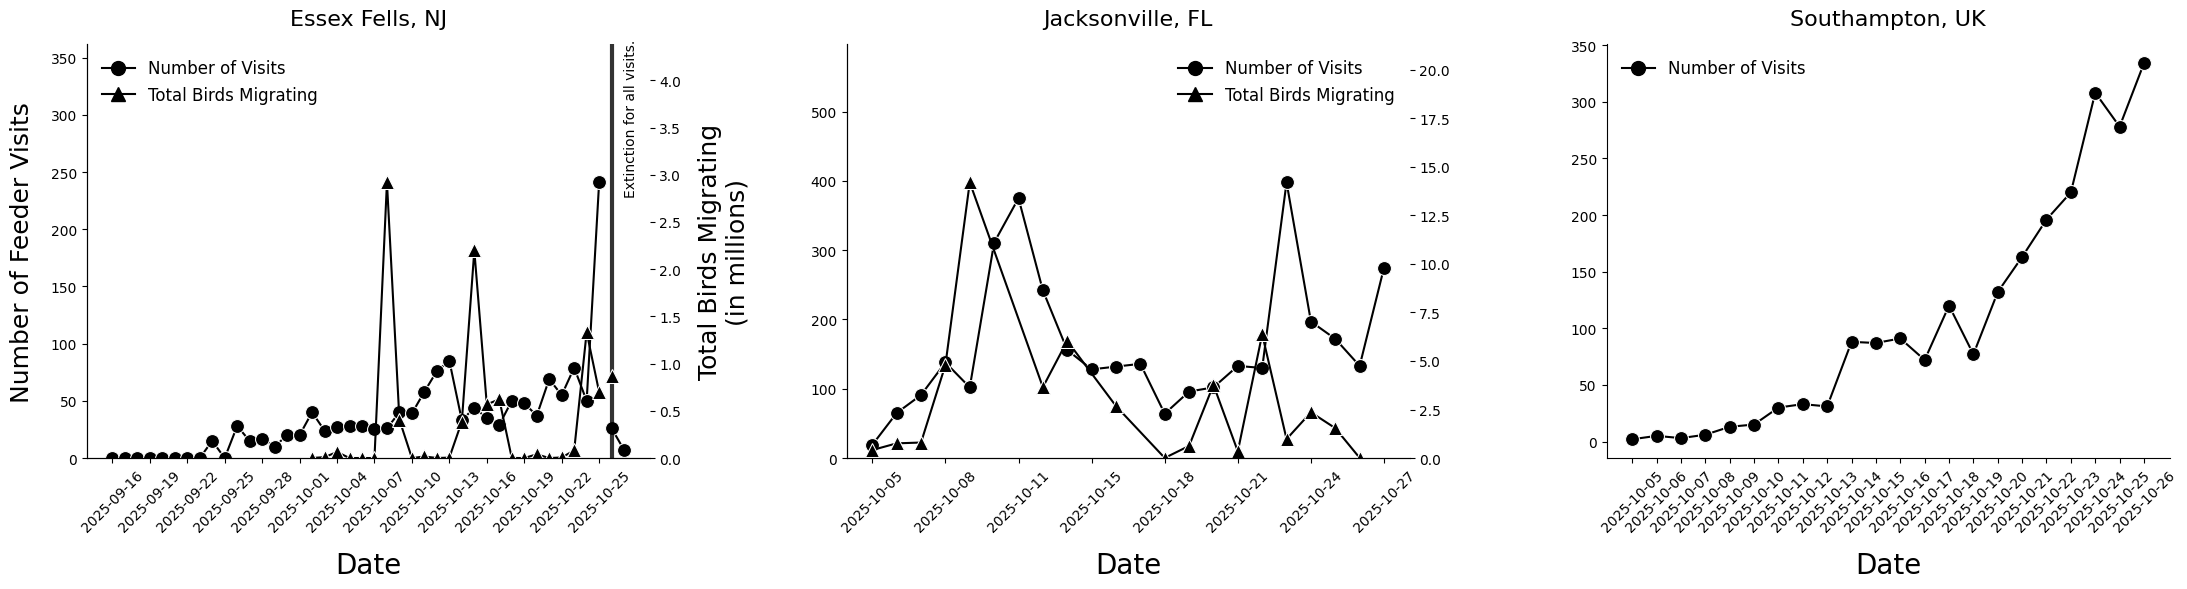

In [ ]:
# Define the regions we want to plot
regions = ['Essex Fells, NJ', 'Jacksonville, FL']

# Create subplot layout (3 total: 2 with migration + 1 Southampton)
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Plot each region separately
for i, region in enumerate(regions):
    ax1 = axes[i]
    
    # Filter merged data for this region
    region_data = merged_data[merged_data['source_sheet'] == region].copy()
    
    # Check for phase changes for this region
    location_phase_changes = phase_changes[phase_changes['LocationOfChange'] == region]
    
    # Get the phase change date if it exists
    phase_change_date = None
    if not location_phase_changes.empty:
        phase_change_date = pd.to_datetime(location_phase_changes.iloc[0]['DateChangeStarted'])
        description = location_phase_changes.iloc[0]['DescriptionOfChange']
    
    # Split feeder visits data at phase change if it exists
    if phase_change_date is not None:
        # Convert Date_str to datetime for comparison
        region_data['Date_dt'] = pd.to_datetime(region_data['Date_str'])
        
        # Split data into before and after phase change
        before_change = region_data[region_data['Date_dt'] < phase_change_date]
        after_change = region_data[region_data['Date_dt'] >= phase_change_date]
        
        # Plot before phase change
        if not before_change.empty:
            sns.lineplot(
                x='Date_str', 
                y='Feeder Visits', 
                data=before_change, 
                ax=ax1, 
                marker='o', 
                markersize=10,
                color='black',
                label='Number of Visits',
                legend=False
            )
        
        # Plot after phase change
        if not after_change.empty:
            sns.lineplot(
                x='Date_str', 
                y='Feeder Visits', 
                data=after_change, 
                ax=ax1, 
                marker='o', 
                markersize=10,
                color='black',
                label='',  # No label for second segment
                legend=False
            )
    else:
        # No phase change, plot normally
        sns.lineplot(
            x='Date_str', 
            y='Feeder Visits', 
            data=region_data, 
            ax=ax1, 
            marker='o', 
            markersize=10,
            color='black',
            label='Number of Visits',
            legend=False
        )
    
    # Create secondary y-axis
    ax2 = ax1.twinx()
    
    # Second lineplot on secondary y-axis (migration data for this region)
    # Only plot if we have migration data
    migration_data = region_data.dropna(subset=['total_birds'])
    if not migration_data.empty:
        # Split migration data at phase change if it exists
        if phase_change_date is not None:
            # Split migration data into before and after phase change
            migration_before = migration_data[migration_data['Date_dt'] < phase_change_date]
            migration_after = migration_data[migration_data['Date_dt'] >= phase_change_date]
            
            # Plot before phase change
            if not migration_before.empty:
                sns.lineplot(
                    x='Date_str',
                    y='total_birds',
                    data=migration_before,
                    ax=ax2,
                    marker='^',
                    markersize=10, 
                    color='black', 
                    label='Total Birds',
                    legend=False
                )
            
            # Plot after phase change
            if not migration_after.empty:
                sns.lineplot(
                    x='Date_str',
                    y='total_birds',
                    data=migration_after,
                    ax=ax2,
                    marker='^',
                    markersize=10, 
                    color='black', 
                    label='',  # No label for second segment
                    legend=False
                )
        else:
            # No phase change, plot normally
            sns.lineplot(
                x='Date_str',
                y='total_birds',
                data=migration_data,
                ax=ax2,
                marker='^',
                markersize=10, 
                color='black', 
                label='Total Birds',
                legend=False
            )
        
        # Set custom scale for secondary y-axis
        ax2.set_ylabel('Total Birds Migrating\n(in millions)', fontsize=18, labelpad=12)
    
    ax1.set_ylim(0, 500)
    
    # Add phase change vertical lines for this region
    for _, phase_row in location_phase_changes.iterrows():
        change_date = pd.to_datetime(phase_row['DateChangeStarted'])
        description = phase_row['DescriptionOfChange']
        
        # Find the actual data points around the change date
        region_dates = region_data['Date_str'].unique()
        region_dates = pd.to_datetime(region_dates)
        region_dates = np.sort(region_dates)
        
        # Find the data point that contains the change date and the next data point
        # Look for the data point that is >= change_date and the next one after it
        change_date_idx = np.where(region_dates >= change_date)[0]
        if len(change_date_idx) > 0:
            # Get the first data point >= change_date
            current_date = region_dates[change_date_idx[0]]
            if change_date_idx[0] + 1 < len(region_dates):
                next_date = region_dates[change_date_idx[0] + 1]
                # Calculate halfway point between current and next data points
                halfway_date = current_date + (next_date - current_date) / 2
            else:
                # If change_date is at or after the last data point, 
                # find the last two data points and put line halfway between them
                if len(region_dates) >= 2:
                    last_date = region_dates[-1]
                    second_last_date = region_dates[-2]
                    halfway_date = second_last_date + (last_date - second_last_date) / 2
                else:
                    # Only one data point, use it
                    halfway_date = region_dates[0]
            
            # Convert to pandas datetime and then to string format to match x-axis
            halfway_date_str = pd.to_datetime(halfway_date).strftime('%Y-%m-%d')
            
            # Add vertical line
            ax1.axvline(x=halfway_date_str, color='black', linestyle='-', linewidth=3, alpha=0.8)
            
            # Add description text
            # Find the next available date string after halfway_date_str
            region_date_strings = sorted(region_data['Date_str'].unique())
            try:
                halfway_idx = region_date_strings.index(halfway_date_str)
                if halfway_idx + 1 < len(region_date_strings):
                    next_date_str = region_date_strings[halfway_idx + 1]
                else:
                    next_date_str = halfway_date_str  # Fallback if no next date
            except ValueError:
                next_date_str = halfway_date_str  # Fallback if halfway_date_str not found

            ax1.text(next_date_str, ax1.get_ylim()[1] / 1.35, description, 
                rotation=90, ha='left', va='top', fontsize=10)
    
    # Set labels for both axes
    if i == 0:  # Only label y-axis for first subplot
        ax1.set_ylabel('Number of Feeder Visits', fontsize=18, labelpad=12)
    else:
        ax1.set_ylabel('')
        ax2.set_ylabel('')
    
    ax1.set_xlabel('Date', fontsize=20, labelpad=12)
    ax1.set_title(region, fontsize=16, pad=14)
    
    # Style the plot
    sns.despine(top=True)
    
    # Adjust x-ticks to avoid collisions
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticks(ax1.get_xticks()[::3])  # Show every 3rd tick

    # Create a combined legend manually for each subplot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits'),
        Line2D([0], [0], color='black', marker='^', linestyle='-', markersize=10, label='Total Birds Migrating')
    ]
    ax1.legend(handles=legend_elements, loc="best", frameon=False, fontsize=12)
    
    # Rotate x-axis labels
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0, migration_data['Feeder Visits'].max() * 1.5)
    ax2.set_ylim(0, migration_data['total_birds'].max() * 1.5)

# Add Southampton, UK subplot (feeder visits only)
ax_southampton = axes[2]

# Filter Southampton data from merged_data
southampton_data = merged_data[merged_data['source_sheet'] == 'Southampton, UK']

# Check for phase changes for Southampton
location_phase_changes_southampton = phase_changes[phase_changes['LocationOfChange'] == 'Southampton, UK']

# Get the phase change date if it exists
phase_change_date_southampton = None
if not location_phase_changes_southampton.empty:
    phase_change_date_southampton = pd.to_datetime(location_phase_changes_southampton.iloc[0]['DateChangeStarted'])
    description_southampton = location_phase_changes_southampton.iloc[0]['DescriptionOfChange']

# Split Southampton data at phase change if it exists
if phase_change_date_southampton is not None:
    # Convert Date_str to datetime for comparison
    southampton_data['Date_dt'] = pd.to_datetime(southampton_data['Date_str'])
    
    # Split data into before and after phase change
    southampton_before = southampton_data[southampton_data['Date_dt'] < phase_change_date_southampton]
    southampton_after = southampton_data[southampton_data['Date_dt'] >= phase_change_date_southampton]
    
    # Plot before phase change
    if not southampton_before.empty:
        sns.lineplot(
            x='Date_str', 
            y='Feeder Visits', 
            data=southampton_before, 
            ax=ax_southampton, 
            marker='o', 
            markersize=10,
            color='black',
            label='Number of Visits',
            legend=False
        )
    
    # Plot after phase change
    if not southampton_after.empty:
        sns.lineplot(
            x='Date_str', 
            y='Feeder Visits', 
            data=southampton_after, 
            ax=ax_southampton, 
            marker='o', 
            markersize=10,
            color='black',
            label='',  # No label for second segment
            legend=False
        )
else:
    # No phase change, plot normally
    sns.lineplot(
        x='Date_str', 
        y='Feeder Visits', 
        data=southampton_data, 
        ax=ax_southampton, 
        marker='o', 
        markersize=10,
        color='black',
        label='Number of Visits',
        legend=False
    )

# Add phase change vertical lines for Southampton
for _, phase_row in location_phase_changes_southampton.iterrows():
    change_date = pd.to_datetime(phase_row['DateChangeStarted'])
    description = phase_row['DescriptionOfChange']
    
    # Find the actual data points around the change date
    southampton_dates = southampton_data['Date_str'].unique()
    southampton_dates = pd.to_datetime(southampton_dates)
    southampton_dates = np.sort(southampton_dates)
    
    # Find the data point that contains the change date and the next data point
    change_date_idx = np.where(southampton_dates == change_date)[0]
    if len(change_date_idx) > 0:
        # Change date exists as a data point
        current_date = southampton_dates[change_date_idx[0]]
        if change_date_idx[0] + 1 < len(southampton_dates):
            next_date = southampton_dates[change_date_idx[0] + 1]
            # Calculate halfway point between current and next data points
            halfway_date = current_date + (next_date - current_date) / 2
            
            # Convert to pandas datetime and then to string format to match x-axis
            halfway_date_str = pd.to_datetime(halfway_date).strftime('%Y-%m-%d')
            
            # Add vertical line
            ax_southampton.axvline(x=halfway_date_str, color='black', linestyle='-', linewidth=3, alpha=0.8)
            
            # Add description text
            # Find the next available date string after halfway_date_str
            southampton_date_strings = sorted(southampton_data['Date_str'].unique())
            try:
                halfway_idx = southampton_date_strings.index(halfway_date_str)
                if halfway_idx + 1 < len(southampton_date_strings):
                    next_date_str = southampton_date_strings[halfway_idx + 1]
                else:
                    next_date_str = halfway_date_str  # Fallback if no next date
            except ValueError:
                next_date_str = halfway_date_str  # Fallback if halfway_date_str not found

            ax_southampton.text(next_date_str, ax_southampton.get_ylim()[1] * 0.95, description, 
                rotation=90, ha='left', va='top', fontsize=10)

# Set y-axis limits
# ax_southampton.set_ylim(0, 500)

# Set labels
ax_southampton.set_ylabel('')
ax_southampton.set_xlabel('Date', fontsize=20, labelpad=12)
ax_southampton.set_title('Southampton, UK', fontsize=16, pad=14)

# Style the plot
sns.despine(top=True)

# Create legend for Southampton (feeder visits only)
from matplotlib.lines import Line2D
legend_elements_southampton = [
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits')
]
ax_southampton.legend(handles=legend_elements_southampton, loc='best', frameon=False, fontsize=12)

# Rotate x-axis labels
ax_southampton.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [ ]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'migration_relation', 
    'Feeder Visits Compared to Migration Activity',
    'Relationship between feeder visits and migration activity from BirdCast data'
)

Saved: Feeder Visits Compared to Migration Activity -> migration_relation


'migration_relation'

## Calculating Daily and Weekly Diversity

In [ ]:
def calculate_species_richness_by_region(daily_summs_df):
    """
    Calculate species richness (number of unique species) per day per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and richness columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    daily = daily[daily['Feeder Visits'] > 0].reset_index(drop=True)
    richness = daily.groupby(["Date", "source_sheet"])["Bird"].nunique().reset_index()
    richness.columns = ['Date', 'source_sheet', 'richness']
    
    return richness

def calculate_shannon_h_by_region(daily_summs_df):
    """
    Calculate Shannon H (alpha diversity) per day per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and shannon_H columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    # Create pivot table: dates and regions as rows, bird species as columns, feeder visits as values
    day_species = daily.pivot_table(
        index=["Date", "source_sheet"], 
        columns="Bird", 
        values="Feeder Visits", 
        aggfunc="sum", 
        fill_value=0
    )
    
    # Calculate proportions (relative abundance) for each species on each day/region
    # Replace 0 with NaN to avoid log(0) issues
    p = day_species.div(day_species.sum(axis=1), axis=0).replace(0, np.nan)
    
    # Calculate Shannon H: -sum(p * log(p))
    shannon = (-(p * np.log(p)).sum(axis=1)).reset_index()
    shannon.columns = ['Date', 'source_sheet', 'shannon_H']
    
    return shannon

def calculate_weekly_sorensen_dissimilarity_by_region(daily_summs_df):
    """
    Calculate Sørensen dissimilarity between consecutive weeks per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily['week'] = daily['Date'].dt.isocalendar().week
    
    # Create weekly presence/absence matrix per region
    weekly_presence = (daily.groupby(["week", "source_sheet", "Bird"])["Feeder Visits"]
                       .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Calculate Sørensen dissimilarity between consecutive weeks for each region
    sorensen = []
    
    for region in daily['source_sheet'].unique():
        region_data = daily[daily['source_sheet'] == region]
        region_weeks = sorted(region_data['week'].unique())
        
        for w_prev, w_curr in zip(region_weeks[:-1], region_weeks[1:]):
            try:
                a = weekly_presence.loc[(w_prev, region)]  # Previous week species presence
                b = weekly_presence.loc[(w_curr, region)]  # Current week species presence
                
                a_sum = a.sum()  # Number of species in previous week
                b_sum = b.sum()  # Number of species in current week
                intersection = (a & b).sum()  # Number of species in both weeks
                
                # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
                denom = (a_sum + b_sum)
                d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
                
                sorensen.append({
                    "week": w_curr, 
                    "source_sheet": region,
                    "sorensen_dissimilarity": d_s
                })
            except KeyError:
                continue
    
    # Convert to DataFrame
    beta_df = pd.DataFrame(sorensen)
    
    # Get all dates and their weeks per region
    all_dates = daily[['Date', 'week', 'source_sheet']].drop_duplicates().sort_values(['source_sheet', 'Date'])
    
    # Merge with Sørensen dissimilarity data
    result_df = all_dates.merge(beta_df, on=['week', 'source_sheet'], how='left')
    result_df = result_df[['Date', 'source_sheet', 'sorensen_dissimilarity']]
    
    return result_df

def calculate_rolling_sorensen_dissimilarity_by_region(daily_summs_df):
    """
    Calculate Sørensen dissimilarity using rolling 3-day comparisons per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and rolling_sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    sorensen_results = []
    
    # Process each region separately
    for region in daily['source_sheet'].unique():
        region_data = daily[daily['source_sheet'] == region].sort_values('Date').reset_index(drop=True)
        
        # Create daily presence/absence matrix for this region
        daily_presence = (region_data.groupby(["Date", "Bird"])["Feeder Visits"]
                          .sum().unstack(fill_value=0) > 0).astype(int)
        
        # Get sorted dates for this region
        dates_sorted = sorted(daily_presence.index)
        
        # Calculate rolling 3-day Sørensen dissimilarity
        for i in range(len(dates_sorted)):
            current_date = dates_sorted[i]
            
            # Define the two 3-day periods to compare
            period_a_dates = []
            period_b_dates = []
            
            # Get dates for period A (7-9 days ago)
            for offset in [9, 8, 7]:
                if i - offset >= 0:
                    period_a_dates.append(dates_sorted[i - offset])
            
            # Get dates for period B (0-2 days ago)
            for offset in [2, 1, 0]:
                if i - offset >= 0:
                    period_b_dates.append(dates_sorted[i - offset])
            
            # Only calculate if we have at least one date in each period
            if len(period_a_dates) > 0 and len(period_b_dates) > 0:
                # Get species presence for each period
                period_a_presence = daily_presence.loc[period_a_dates].any(axis=0)
                period_b_presence = daily_presence.loc[period_b_dates].any(axis=0)
                
                # Calculate Sørensen dissimilarity
                a_sum = period_a_presence.sum()
                b_sum = period_b_presence.sum()
                intersection = (period_a_presence & period_b_presence).sum()
                
                # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
                denom = (a_sum + b_sum)
                d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
                
                sorensen_results.append({
                    'Date': current_date,
                    'source_sheet': region,
                    'rolling_sorensen_dissimilarity': d_s
                })
            else:
                sorensen_results.append({
                    'Date': current_date,
                    'source_sheet': region,
                    'rolling_sorensen_dissimilarity': np.nan
                })
    
    # Create result DataFrame
    result_df = pd.DataFrame(sorensen_results)
    
    return result_df

# Calculate each metric separately
richness_df = calculate_species_richness_by_region(daily_summs)
shannon_df = calculate_shannon_h_by_region(daily_summs)
weekly_sorensen_df = calculate_weekly_sorensen_dissimilarity_by_region(daily_summs)
rolling_sorensen_df = calculate_rolling_sorensen_dissimilarity_by_region(daily_summs)

# Merge all metrics into a single dataframe
diversity_metrics_clean = richness_df.merge(shannon_df, on=['Date', 'source_sheet'], how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(weekly_sorensen_df, on=['Date', 'source_sheet'], how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(rolling_sorensen_df, on=['Date', 'source_sheet'], how='outer')

# Sort by date and region
diversity_metrics_clean = diversity_metrics_clean.sort_values(['source_sheet', 'Date']).reset_index(drop=True)

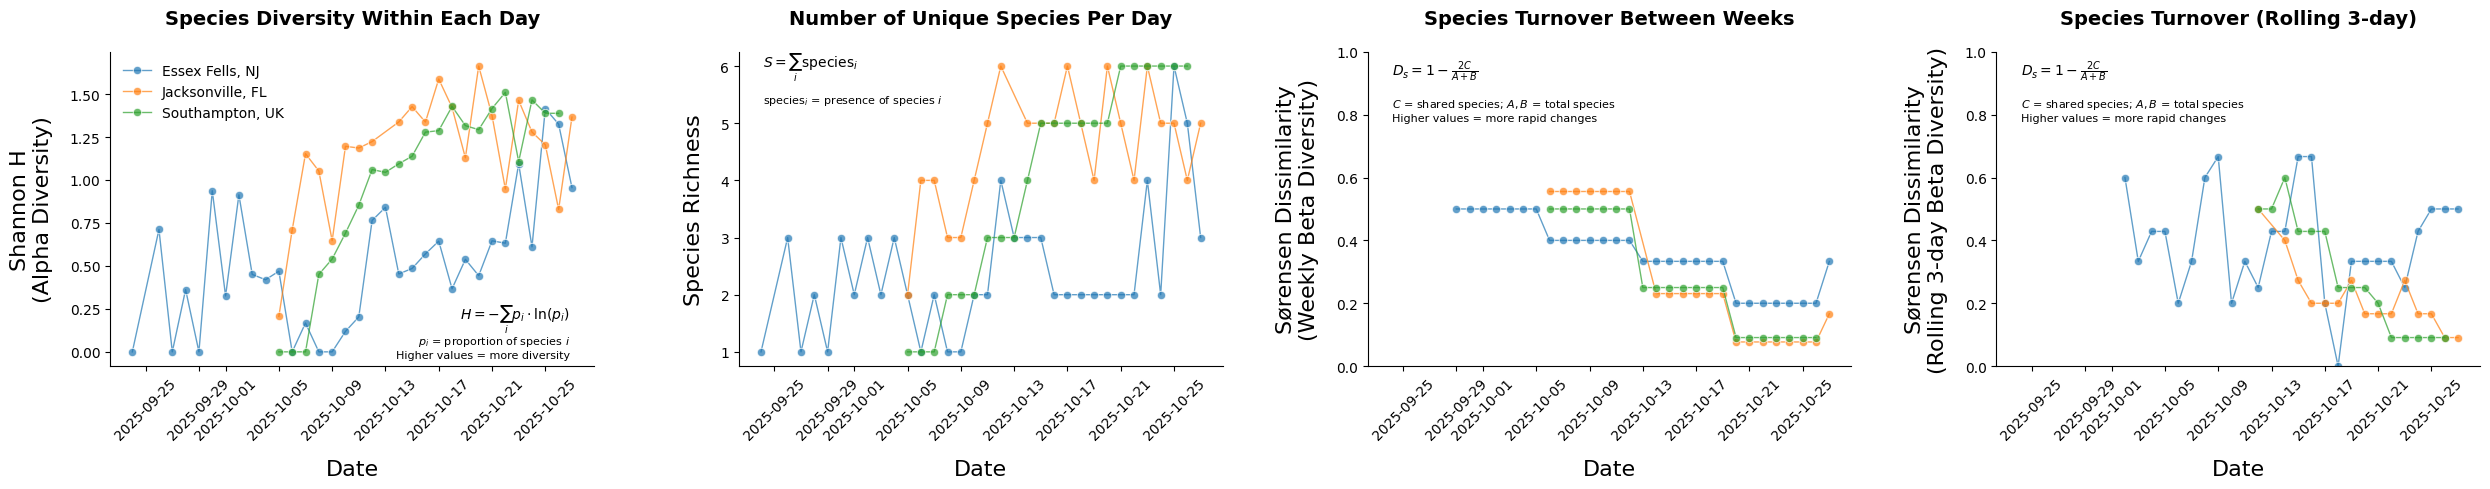

In [ ]:
# Create 1x4 subplot layout with all four metrics
fig, axes = plt.subplots(1, 4, figsize=(25, 5), sharex=True)

# Define plot configurations
plot_configs = [
    {
        'ax': axes[0],
        'y_col': 'shannon_H',
        'title': 'Species Diversity Within Each Day',
        'ylabel': 'Shannon H\n(Alpha Diversity)',
        'show_legend': True,
        'equation': r'$H = -\sum_{i} p_i \cdot \ln(p_i)$',
        'description': '$p_i$ = proportion of species $i$\nHigher values = more diversity',
        'eq_pos': (0.95, 0.10),
        'desc_pos': (0.95, 0.02),
        'eq_align': 'right'
    },
    {
        'ax': axes[1],
        'y_col': 'richness',
        'title': 'Number of Unique Species Per Day',
        'ylabel': 'Species Richness',
        'show_legend': False,
        'equation': r'$S = \sum_{i} \text{species}_i$',
        'description': r'$\text{species}_i$ = presence of species $i$',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.825),
        'eq_align': 'left'
    },
    {
        'ax': axes[2],
        'y_col': 'sorensen_dissimilarity',
        'title': 'Species Turnover Between Weeks',
        'ylabel': 'Sørensen Dissimilarity\n(Weekly Beta Diversity)',
        'show_legend': False,
        'equation': r'$D_s = 1 - \frac{2C}{A + B}$',
        'description': '$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.775),
        'eq_align': 'left',
        'ylim': (0, 1),
        'data_filter': lambda df: df.dropna(subset=['sorensen_dissimilarity'])
    },
    {
        'ax': axes[3],
        'y_col': 'rolling_sorensen_dissimilarity',
        'title': 'Species Turnover (Rolling 3-day)',
        'ylabel': 'Sørensen Dissimilarity\n(Rolling 3-day Beta Diversity)',
        'show_legend': False,
        'equation': r'$D_s = 1 - \frac{2C}{A + B}$',
        'description': '$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.775),
        'eq_align': 'left',
        'ylim': (0, 1),
        'data_filter': lambda df: df.dropna(subset=['rolling_sorensen_dissimilarity'])
    }
]

# Plot all subplots using the configuration
for config in plot_configs:
    ax = config['ax']
    
    # Filter data if needed
    plot_data = config.get('data_filter', lambda df: df)(diversity_metrics_clean)
    
    if not plot_data.empty:
        # Create the lineplot
        sns.lineplot(
            x='Date', 
            y=config['y_col'], 
            hue='source_sheet',
            data=plot_data, 
            ax=ax, 
            marker='o', 
            markersize=6,
            linewidth=1, 
            alpha=0.7
        )
        
        # Set labels and title
        ax.set_ylabel(config['ylabel'], fontsize=16, labelpad=12)
        ax.set_xlabel('Date', fontsize=16, labelpad=12)
        ax.set_title(config['title'], fontsize=14, fontweight='bold', pad=20)
        
        # Set y-axis limits if specified
        if 'ylim' in config:
            ax.set_ylim(config['ylim'])
        
        # Handle legend
        if config['show_legend']:
            ax.legend(loc='upper left', frameon=False, fontsize=10)
        else:
            ax.legend().remove()
        
        # Add equation and description
        ax.text(config['eq_pos'][0], config['eq_pos'][1], config['equation'], 
               transform=ax.transAxes, fontsize=10, 
               ha=config['eq_align'], va='bottom')
        ax.text(config['desc_pos'][0], config['desc_pos'][1], config['description'], 
               transform=ax.transAxes, fontsize=8, 
               ha=config['eq_align'], va='bottom')
    else:
        # Show "no data" message
        ax.text(0.5, 0.5, f'No {config["y_col"]} data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    # Apply styling
    sns.despine(top=True, right=True, ax=ax)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
# Save diversity metrics plot for dashboard
save_plot_for_dashboard(
    fig, 
    'diversity_metrics', 
    'Ecological Diversity Metrics',
    'Shannon H diversity and species richness metrics over time'
)

Saved: Ecological Diversity Metrics -> diversity_metrics


'diversity_metrics'